In [41]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pandas as pd

In [42]:
folder_path = r'C:\Users\daV\Documents\ZHAW\HS 2024\dPoDL\dPoDL\experiments\filtered-search\cnns\cifar10\categorical'
sequences = []

# Load all CSVs and extract sequences of loss values
for filename in [i for i in os.listdir(folder_path) if i.endswith(".csv")]:
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            data = pd.read_csv(file_path)
            if len(data) >= 3: 
                values_temp = data['Loss'].values
                if max(values_temp) < 2 and min(values_temp) > 0:  # make sure data makes sense
                    sequences.append(values_temp)
        except Exception as e:
            print(e, filename)


### Conditions when to stop:
- values start to increase -> max increase allowed: 0.005 for 3 epochs straight
- values don't decrease sufficiently -> min decrease: 0.003

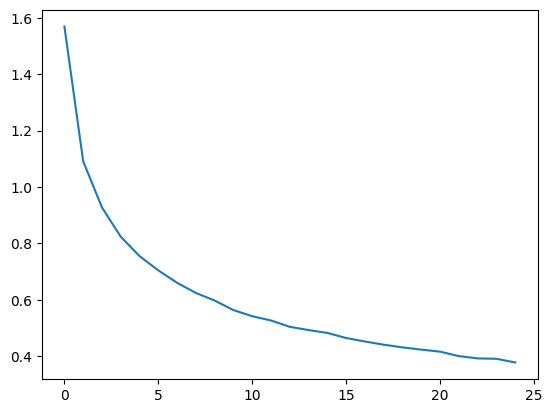

In [43]:
def find_stabilization_point(
    sequence,
    window=5,
    slope_threshold=0.005,
    curvature_threshold=0.05,
    patience=1,
    oscillation_tolerance=0.001,
    increasing_trend_threshold=0.01,
    flat_change_threshold=0.003 
):
    if len(sequence) < window * 2:
        return float("inf")

    # Smooth the sequence using a moving average
    smoothed_sequence = np.convolve(sequence, np.ones(window) / window, mode='valid')

    # Calculate slopes and curvatures
    slopes = np.diff(smoothed_sequence) / smoothed_sequence[:-1]
    curvatures = np.diff(slopes)

    stabilization_count = 0
    for i in range(len(slopes) - window):
        recent_slopes = slopes[i: i + window]
        recent_curvatures = curvatures[i: i + window - 1]

        # Stabilization conditions
        is_stabilized = (
            np.all(np.abs(recent_slopes) < slope_threshold) and
            np.all(np.abs(recent_curvatures) < curvature_threshold)
        )

        # Oscillation detection
        recent_values = smoothed_sequence[i: i + window]
        oscillation_range = np.ptp(recent_values)
        is_oscillating = oscillation_range < oscillation_tolerance

        # Increasing trend detection
        has_increasing_trend = np.all(recent_slopes > increasing_trend_threshold)

        # Flat change detection
        flat_change = np.abs(smoothed_sequence[i + window - 1] - smoothed_sequence[i]) < flat_change_threshold

        if is_stabilized or is_oscillating or flat_change:
            stabilization_count += 1
            if stabilization_count >= patience:
                return i + window
        elif has_increasing_trend:
            return i + window
        else:
            stabilization_count = 0

    return float("inf")



# Example usage:
random.seed(42)
for sequence in random.sample(sequences, 1):
    stable_point = find_stabilization_point(sequence)
    plt.plot(sequence)
    if stable_point < len(sequence):
        plt.axvline(x=stable_point, color='r', linestyle='--', label='stable_point')
    plt.show()


In [47]:
d = {'loss': [1.7407809495925903,
  1.3847315311431885,
  1.2064924240112305,
  1.0438499450683594,
  0.8914356827735901,
  0.7533888220787048,
  0.6390976309776306,
  0.5243375301361084,
  0.4378274977207184,
  0.3847949802875519,
  0.3286530375480652,
  0.2863883674144745,
  0.25639793276786804,
  0.25311386585235596,
  0.19903650879859924],
 'accuracy': [0.3620544970035553,
  0.5010200142860413,
  0.5680426955223083,
  0.6248649954795837,
  0.6813872456550598,
  0.7258490324020386,
  0.772710919380188,
  0.8123725056648254,
  0.8478938937187195,
  0.865894615650177,
  0.8866554498672485,
  0.8988959789276123,
  0.9141965508460999,
  0.9157566428184509,
  0.931297242641449],
 'val_loss': [1.4634143114089966,
  1.424943208694458,
  1.524335503578186,
  1.5255465507507324,
  1.591677188873291,
  1.8013015985488892,
  1.9869176149368286,
  2.1498770713806152,
  2.525686025619507,
  2.89542555809021,
  3.0567407608032227,
  3.2800793647766113,
  3.7315237522125244,
  3.8016881942749023,
  4.1012372970581055],
 'val_accuracy': [0.45809999108314514,
  0.49619999527931213,
  0.46230000257492065,
  0.4993000030517578,
  0.5116999745368958,
  0.4803999960422516,
  0.4984999895095825,
  0.49970000982284546,
  0.4781999886035919,
  0.486299991607666,
  0.47380000352859497,
  0.46939998865127563,
  0.47049999237060547,
  0.48010000586509705,
  0.48080000281333923]}

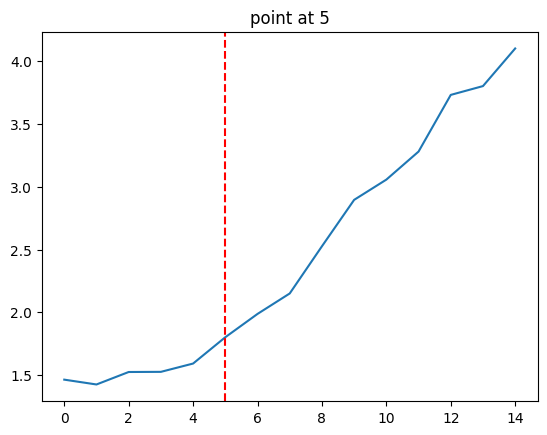

In [52]:
l = [1.4634143114089966, 1.424943208694458, 1.524335503578186, 1.5255465507507324, 1.591677188873291, 1.8013015985488892, 1.9869176149368286, 2.1498770713806152, 2.525686025619507, 2.89542555809021, ]
l.append(1.3618)
for sequence in (d["val_loss"], ):
    stable_point = find_stabilization_point(
    sequence
)
    plt.plot(sequence)
    plt.title(f"point at {stable_point}")
    if stable_point < len(sequence):
        plt.axvline(x=stable_point, color='r', linestyle='--', label='stable_point')
    plt.show()

# to-do
- placement of report, e.g. double descent erwähnen, modular anwendung auch für zukunft andere anwendungsfälle
- vortrag helmut letzte Januarwoche im IDP
- mechanismus dass predicted "halluzinogen" wenn genug confident
- zusammensetzen der teile!
- report beginnen zu schreiben

In [ ]:
MIN_DECREASE = -0.001
MAX_INCREASE = 0.0005
WINDOW = 20
SLACK_RATE_DECREASE, SLACK_RATE_INCREASE = 0.3, 0.5
SLACK_RATE_DECREASE, SLACK_RATE_INCREASE = SLACK_RATE_DECREASE * WINDOW, SLACK_RATE_INCREASE * WINDOW


def find_stabilization_point(sequence):
    """
    Identifies the point at which the sequence stops significantly decreasing.

    :param sequence: List of float values (the sequence to analyze)
    :return: The index of the first value where the sequence stops significantly decreasing, or None if not found
    """

    if len(sequence) < 2:
        return float("inf")  # A sequence with less than 2 values can't have a significant decrease

    for i in range(WINDOW, len(sequence)):
        s = sequence[i - WINDOW: i]
        if any([s[j+1] < 0.25 * s[0] for j in range(len(s) - 1) ]):  # if any of the following values is smaller than 60% of start value, no we declare no point was found
            return float("inf")
    

    changes = []  # List to track the relative changes in values
    for i in range(1, len(sequence)):
        change = (sequence[i] - sequence[i - 1]) / abs(sequence[i - 1])
        changes.append(change)

    # Check if consecutive changes are consistently smaller than the threshold
    for i in range(WINDOW, len(changes)):
        # Consider the last few changes for oscillation detection
        # check for increasing behaviour:
        s = sequence[i - WINDOW: i]
        condition1 = not any(0.5 * s[0] > [s[j+1]  for j in range(len(s) - 1) ])  # if any of the following values is smaller than 50% of start value, we declare no point was found
        condition1 = True
        if condition1 and [change > MAX_INCREASE for change in changes[i - WINDOW: i]].count(True) >= SLACK_RATE_INCREASE: 
            return i - WINDOW

        # check for decreasing behaviour:
        if condition1 and [change > MIN_DECREASE for change in changes[i - WINDOW: i]].count(True) >= SLACK_RATE_DECREASE:
            return i

    return float("inf")  # No stabilization point found
